baseline model is what COMPASS predicted

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import functools
import matplotlib.pyplot as plt
from cinny import *

## Read training dataset from CSV

In [3]:
df = pd.read_csv('https://storage.googleapis.com/what-if-tool-resources/computefest2019/cox-violent-parsed_filt.csv')

In [3]:
df.shape

(18316, 40)

In [4]:
df.head(2)

,id,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,...,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,priors_count.1,event
0,1.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0
1,2.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0


## Specify input columns and columns to predict

In [4]:
# Filter out entries with no indication of recidivism or no compass score
df = df[df['is_recid'] != -1]
df = df[df['decile_score'] != -1]

# Rename recidivism column
df.rename(columns={'is_recid': 'recidivism_within_2_years'}, inplace=True)

# Make the COMPASS label column numeric (0 and 1), for use in our model
df['COMPASS_determination'] = np.where(df['score_text'] == 'Low', 0, 1)

# Set column to predict
label_column = 'COMPASS_determination'

# Get list of all columns from the dataset we will use for model input or output.
input_features = ['sex', 'age', 'race', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']
features_and_labels = input_features + [label_column]

features_for_file = input_features + ['recidivism_within_2_years', 'COMPASS_determination']

In [6]:
df.columns

Index(['id', 'name', 'first', 'last', 'sex', 'dob', 'age', 'age_cat', 'race',
       'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc',
       'recidivism_within_2_years', 'r_charge_degree', 'r_days_from_arrest',
       'r_offense_date', 'r_charge_desc', 'r_jail_in', 'violent_recid',
       'is_violent_recid', 'vr_charge_degree', 'vr_offense_date',
       'vr_charge_desc', 'type_of_assessment', 'decile_score.1', 'score_text',
       'screening_date', 'v_type_of_assessment', 'v_decile_score',
       'v_score_text', 'priors_count.1', 'event', 'COMPASS_determination'],
      dtype='object')

In [1]:
def sex_num(x):
    if x=='Male':
        return 1
    else:
        return 0

def race_num(x):
    if (x=='African-American') | (x=='Hispanic'):
        return 1
    else:
        return 0

In [5]:
df['sex_num'] = df['sex'].apply(sex_num)
df['race_num'] = df['race'].apply(race_num)

In [7]:
# df.to_csv('../data/compas_florida.csv', index=False)

## Model Evaluation
-- Cinny's prelim eval of the baseline model

### Accuracy
`Accuracy = (TP+TN)/(TP+FP+FN+TN)`

Accuracy is a valid choice of evaluation for classification problems which are well balanced and not skewed or No class imbalance.

In [7]:
get_accuracy(df)

0.6261799874134676

### Precision
`Precision = (TP)/(TP+FP)`

Precision is a valid choice of evaluation metric when we want to be very sure of our prediction.

In [8]:
get_precision(df)

0.6002136752136752

### Recall

`Recall = (TP)/(TP+FN)`

Recall is a valid choice of evaluation metric when we want to capture as many positives as possible.

In [9]:
get_recall(df)

0.6680142687277051

### F1 Score

`F1 = 2 * (precision * recall) / (precision + recall)`

The F1 score is a number between 0 (worst) and 1 (best). It is used when you want your model to have both good precision and recall.

### F_beta

`F_beta = (1 + beta^2) * (precision * recall) / ( (beta^2 * precision) + recall )`

The F1 score gives equal weight to precision and recall. `beta` means we give `beta` times more importance to recall as precision.

In [10]:
get_f1(df)

0.6323016319639843

## Bias Assessment

In [11]:
df.groupby(['race', 'recidivism_within_2_years', 'COMPASS_determination']).count()['name']

race              recidivism_within_2_years  COMPASS_determination
African-American  0                          0                        1948
                                             1                        2388
                  1                          0                        1258
                                             1                        3818
Asian             0                          0                          37
                                             1                           8
                  1                          0                           7
                                             1                          12
Caucasian         0                          0                        2276
                                             1                        1025
                  1                          0                        1073
                                             1                        1399
Hispanic          0              

In [12]:
propublica_analysis(df)

(0.4885605338417541,
 0.511439466158246,
 0.6549643444871092,
 0.34503565551289084)

In [13]:
fp1 = 6+629+3+65
fn1 = 2+653+2+165
fp2 = 1421+143
fn2 = 746+132

In [14]:
fp1/(fp1+fn1)

0.460983606557377

In [15]:
fn1/(fp1+fn1)

0.539016393442623

In [16]:
fp2/(fp2+fn2)

0.6404586404586404

In [17]:
fn2/(fp2+fn2)

0.3595413595413595

### Duplicate Propublilca Analysis

Prediction Fails Differently for Black Defendants ([source](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing))

|                                           | White | African American |
|-------------------------------------------|-------|------------------|
| Labeled Higher Risk, But Didn’t Re-Offend | 49%   | 66%              |
| Labeled Lower Risk, Yet Did Re-Offend     | 51%   | 34%              |

|                                           | White, Asian, etc. | African American or Hispanic |
|-------------------------------------------|--------------------|-------------------------------------|
| Labeled Higher Risk, But Didn’t Re-Offend | 46%                | 64%              |
| Labeled Lower Risk, Yet Did Re-Offend     | 54%                | 36%              |

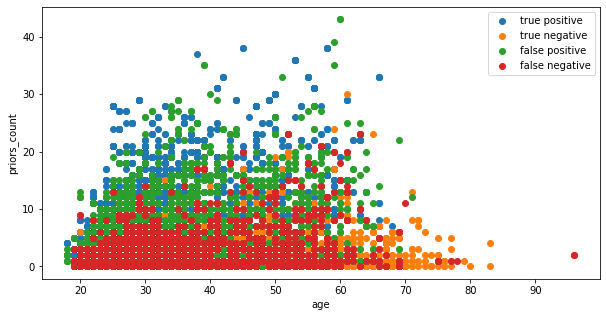

In [18]:
plot_scatter(df)

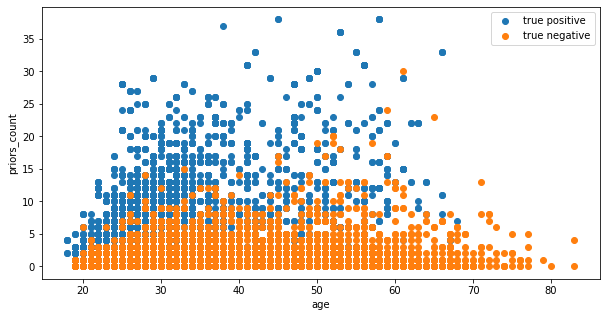

In [19]:
plot_scatter(df, false_positive=False, false_negative=False)

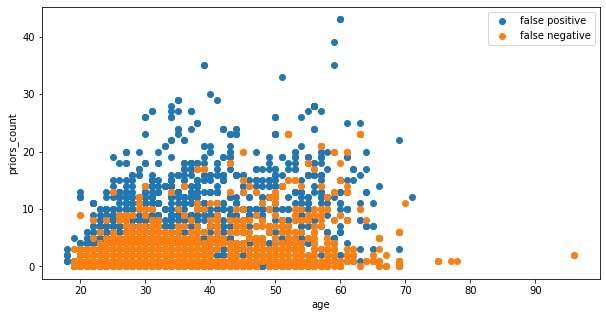

In [20]:
plot_scatter(df, true_positive=False, true_negative=False)

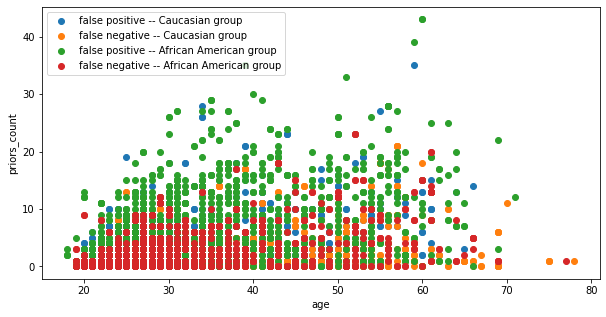

In [21]:
plot_scatter(df, race=True)